# Textual embeddings Notebook

#### Big issue with memory --> May need to move the embedding into the __getitem__ method --> Will make code slower however

In [1]:
# Imports
import os
import pandas as pd
import numpy as np

In [2]:
data_path = '../data/Bert_data/'
train_path = data_path + 'train_df_wQuery_.jsonl'
test_path = data_path + 'test_seen_df_wQuery_.jsonl'

In [3]:
train_df = pd.read_json(train_path, lines=True)
test_df = pd.read_json(test_path, lines=True)

In [4]:
print(f"Lengths of train and test set: {len(train_df)}, {len(test_df)}")

Lengths of train and test set: 8500, 1000


In [5]:
train_df.head()

,id,img,label,text,query_1
0,42953,img/42953.png,0,its their character not their color that matters,The image presents two distinct portraits of a...
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,The image captures a tender moment between a m...
2,13894,img/13894.png,0,putting bows on your pet,The image presents two photos of a gray cat ad...
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,The image is a collage of two photos featuring...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",The image is a black and white photograph feat...


In [6]:
# Importing Bert
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

c:\Users\lucha\anaconda3\envs\mnlp-venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [8]:
max_len_train = train_df['query_1'].apply(lambda n: len(n.split())).max()
print(f"Longest description: {max_len_train}")

Longest description: 841


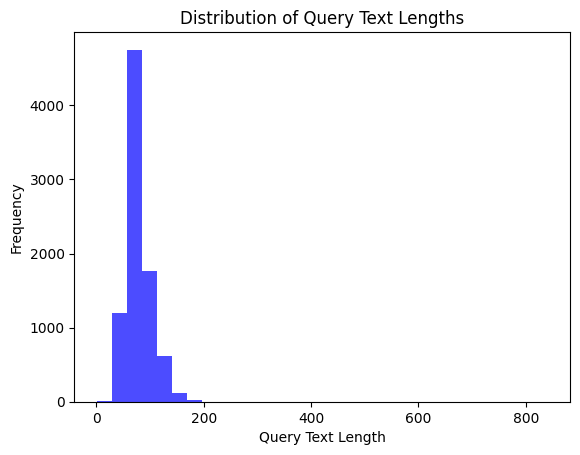

In [10]:
import matplotlib.pyplot as plt

# Calculate the lengths
query_lengths = train_df['query_1'].apply(lambda n: len(n.split()))

# Create a histogram
plt.hist(query_lengths, bins=30, alpha=0.7, color='b')

# Add title and labels
plt.title('Distribution of Query Text Lengths')
plt.xlabel('Query Text Length')
plt.ylabel('Frequency')

# Show the plot
plt.show()

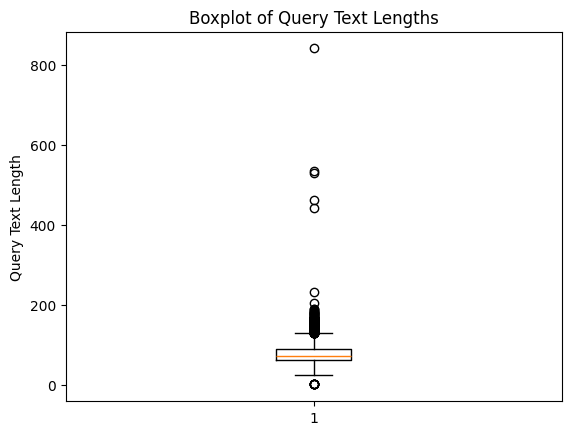

Max length:  841
Min length:  1
Average length:  78.03741176470588
Standard deviation:  26.294668465743364


In [20]:
# Create a boxplot
plt.boxplot(query_lengths)
plt.title('Boxplot of Query Text Lengths')
plt.ylabel('Query Text Length')
plt.show()

# Print statistics
print("Max length: ", query_lengths.max())
print("Min length: ", query_lengths.min())
print("Average length: ", query_lengths.mean())
print("Standard deviation: ", query_lengths.std())

In [21]:
# Find out how many are over 512 words
over_512 = sum(query_lengths > 512)

print("Number of queries over 512 words: ", over_512)

Number of queries over 512 words:  3


In [22]:
print(len(query_lengths))

8500


In [11]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, model, max_len = 512):
        self.df = df
        self.tokenizer = tokenizer
        self.text = df['query_1']
        self.labels = df['label']
        self.ids = df['id']
        self.max_len = max_len
        
        # Bert Model
        self.model = model
        
        self.embeddings = []
        sentences = df['query_1'].tolist() # List of sentences
        
        inputs = tokenizer(
            sentences,
            padding=True,
            truncation=True,  # Apply truncation to ensure sequences don't exceed the model's token limit
            return_tensors='pt'  # Return PyTorch tensors
        )       
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
            
        with torch.no_grad():
            outputs = model(**inputs)
                
        # Get the embeddings of the [CLS] token
        embeddings_list = outputs.last_hidden_state[:,0,:].tolist() # output is a context vector of 768 dimensions
        self.embeddings = embeddings_list
        
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return {
            'id': self.ids[idx],
            'embeddings': torch.tensor(self.embeddings[idx], dtype=torch.float),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [12]:
# Limit to 50 samples to ensure that I have enough memory
train_dataset = TextDataset(train_df[:100], tokenizer, model)

In [13]:
# Sanity check
print(f"The number of ids is: {(len(train_dataset))}")

The number of ids is: 100


In [14]:
# Fun test with Tiny neural net
import torch.nn as nn
import torch.optim as optim

class TinyNet(nn.Module):
    def __init__(self):
        super(TinyNet, self).__init__()
        self.fc1 = nn.Linear(768, 100)
        self.fc2 = nn.Linear(100, 2)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model_ = TinyNet()

# Losses and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_.parameters(), lr = 0.01)

# Create a DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle = True)

In [15]:
def is_empty(data_loader):
    try:
        iterator = iter(data_loader)
        next(iterator)
        return False
    except StopIteration:
        return True

# Check if train_loader is empty
if is_empty(train_loader):
    print("The DataLoader is empty.")
else:
    print("The DataLoader is not empty.")

The DataLoader is not empty.


In [16]:
# Training Loop
for epoch in range(15):  # 15 epochs
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a dictionary
        inputs, labels = data['embeddings'], data['labels']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [17]:
test_dataset = TextDataset(test_df[:50], tokenizer, model)

In [18]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

In [19]:
# switch the model to evaluation mode
model_.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data['embeddings'], data['labels']
        outputs = model_(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test data: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test data: 6 %
